In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('superstoredata.csv', sep=',')

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34


In [4]:
df.shape

(541909, 9)

In [5]:
# Проверяем наличие пустых значений
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
Sales               0
dtype: int64

In [6]:
df[df['CustomerID'].isna() == True].sort_values('Sales')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
524602,C580605,AMAZONFEE,AMAZON FEE,-1,12/5/2011 11:36,17836.46,NaN,United Kingdom,-17836.46
43702,C540117,AMAZONFEE,AMAZON FEE,-1,1/5/2011 9:55,16888.02,NaN,United Kingdom,-16888.02
43703,C540118,AMAZONFEE,AMAZON FEE,-1,1/5/2011 9:57,16453.71,NaN,United Kingdom,-16453.71
15016,C537630,AMAZONFEE,AMAZON FEE,-1,12/7/2010 15:04,13541.33,NaN,United Kingdom,-13541.33
16356,C537651,AMAZONFEE,AMAZON FEE,-1,12/7/2010 15:49,13541.33,NaN,United Kingdom,-13541.33
...,...,...,...,...,...,...,...,...,...
268028,560373,M,Manual,1,7/18/2011 12:30,4287.63,NaN,United Kingdom,4287.63
297723,562955,DOT,DOTCOM POSTAGE,1,8/11/2011 10:14,4505.17,NaN,United Kingdom,4505.17
467804,576365,22086,PAPER CHAIN KIT 50'S CHRISTMAS,688,11/14/2011 17:55,6.95,NaN,United Kingdom,4781.60
299982,A563185,B,Adjust bad debt,1,8/12/2011 14:50,11062.06,NaN,United Kingdom,11062.06


In [7]:
# Удаляем пустые значения, так как в данном случае они больше похоже на административные расходы, не привязанные к конкретным клиентам
df = df.dropna(subset=['CustomerID'])

In [8]:
# И дополнительно удалим также ручные корректировки данных (manual)
df = df.drop(df[df['Description'] == 'Manual'].index)

In [9]:
df.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
Sales          0
dtype: int64

In [10]:
# Проверяем наличие дубликатов
df[df.duplicated() == True].count()

InvoiceNo      5220
StockCode      5220
Description    5220
Quantity       5220
InvoiceDate    5220
UnitPrice      5220
CustomerID     5220
Country        5220
Sales          5220
dtype: int64

In [11]:
# Удаляем дубликаты
df = df.drop_duplicates()

In [12]:
# Смотрим на кол-во уникальных клиентов
df.CustomerID.nunique()

4363

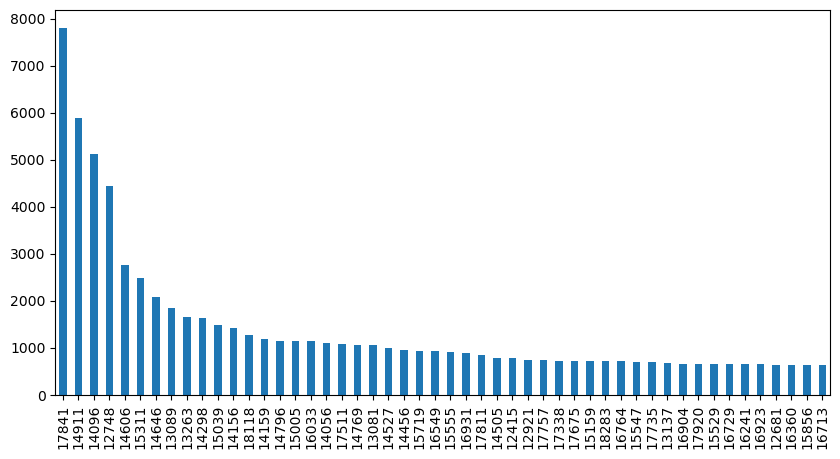

In [13]:
# Посмотрим на топ-50 клиентов по частоте покупок
df['CustomerID'] = df['CustomerID'].astype(int)
df['CustomerID'].value_counts().head(50).plot(kind='bar', figsize=(10, 5))
plt.show()

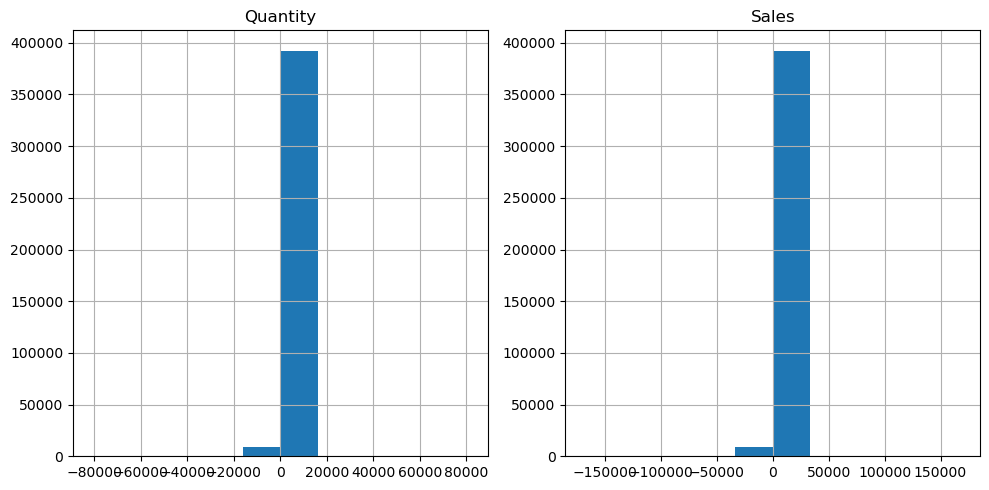

In [14]:
# Построим гистограммы для основнхы числовых переменных
df[['Quantity', 'Sales']].hist(bins=10, figsize=(10, 5))
plt.tight_layout()
plt.show()

Видим, что данные имеют выбросы, также отрицательные значения

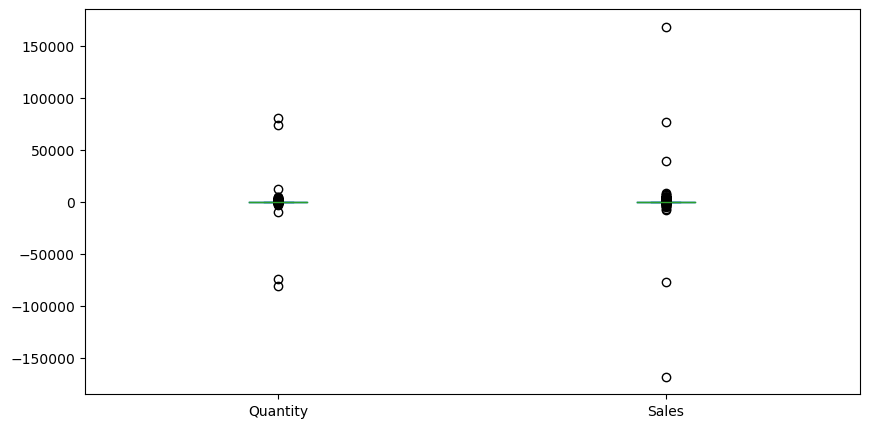

In [15]:
# Построим еще Boxplot для числовых переменных
df[['Quantity', 'Sales']].plot(kind='box', figsize=(10, 5))
plt.show()

In [16]:
# И посмотрим на основные статистики распределения
df[['Quantity', 'Sales']].describe()

,Quantity,Sales
count,401144.000000,401144.000000
mean,12.189904,20.783721
std,250.385375,425.221326
min,-80995.000000,-168469.600000
25%,2.000000,4.250000
50%,5.000000,11.700000
75%,12.000000,19.800000
max,80995.000000,168469.600000


Поработаем с выбросами. Из описательных статистик видно, что есть отрицательные значения, причем некоторые такие данные дублируются с положительным значением, а значит, мы, скорее всего, имеем дело с возвратом товаров. Причем опять же судя по стандартному отклонению, медине и мин/макс значениям эти "покупки" могли быть произведены случайно (техническая ошибка, человеческий фактор) так как они не тичпичны для всего распределения и аномально большие.

In [17]:
# Для начала попытаем определить покупки, по которым в последствии был осуществлен возврат
df['Quantity_abs'] = df['Quantity'].abs()
df_returns = df.groupby(['StockCode', 'UnitPrice', 'CustomerID', 'Quantity_abs']).filter(lambda x: len(x) == 2 and x['Quantity'].sum() == 0)

In [18]:
# Определяем кол-во таких транзакцией
df_returns.shape

(3958, 10)

In [19]:
# Исключим получившиеся транзакции из датафрейма
merged_df = df.merge(df_returns, on=['StockCode', 'Quantity', 'UnitPrice', 'CustomerID'], how='left', indicator=True)
df = merged_df[merged_df['_merge'] == 'left_only'].drop(columns=['_merge', 'Quantity_abs_x', 'InvoiceNo_y', 'Description_y', 'InvoiceDate_y', 'Country_y', 'Sales_y', 'Quantity_abs_y'])
df = df.rename(columns={'InvoiceNo_x':'InvoiceNo', 'Description_x':'Description', 'InvoiceDate_x':'InvoiceDate', 'Country_x':'Country', 'Sales_x':'Sales'})

In [20]:
# Проверяем корректность выполненных выше операцией
df.shape

(397186, 9)

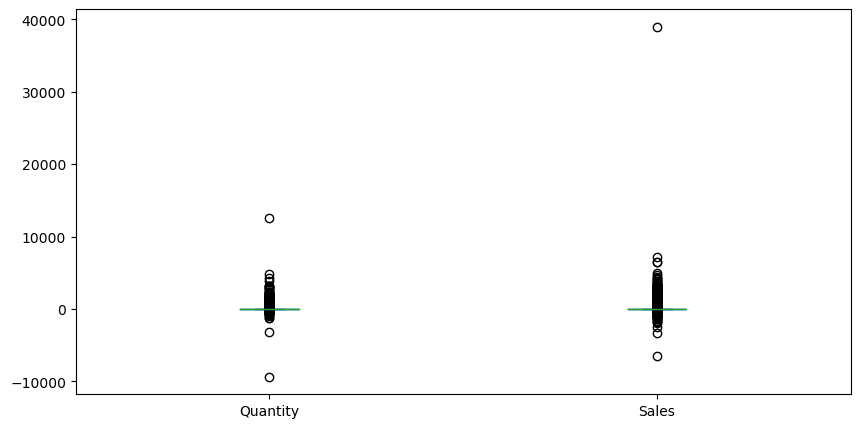

In [21]:
# Еще раз смотрим на распределение
df[['Quantity', 'Sales']].plot(kind='box', figsize=(10, 5))
plt.show()

In [22]:
df[['Quantity', 'Sales']].describe()

,Quantity,Sales
count,397186.000000,397186.000000
mean,12.311378,20.990833
std,49.579568,94.221727
min,-9360.000000,-6539.400000
25%,2.000000,4.350000
50%,5.000000,11.700000
75%,12.000000,19.800000
max,12540.000000,38970.000000


В целом получше, но все еще недостаточно, выбрасов все равно остается достаточно много. В данном случае для нас это критично, так как они будут искажать все последующие результаты анализа.
Для того, чтобы уменьшить влияние выбросов на данные воспользуемся интерквартильным размахом. На мой взгляд, здесь этот метод будет уместнее, чем замена выбросов на медиану или среднее. 

In [23]:
# С помощью функции определим границы выбросов через IQR
def define_iqr(df, var, coefficient):
    q1 = df[var].quantile(0.25)
    q3 = df[var].quantile(0.75)
    iqr = q3 - q1
    iqr_bottom = round(q1 - coefficient * iqr, 2)
    iqr_up = round(q3 + coefficient * iqr, 2)
    return iqr_bottom, iqr_up

In [24]:
# Для корректного определения коэффициента посмотрим еще на распределение данных с помощью квантилей
quantilies = [round(x, 2) for x in np.arange(0.1, 1.1, 0.1)]
df[['Quantity', 'Sales']].quantile(quantilies)

,Quantity,Sales
0.1,1.0,1.69
0.2,2.0,3.40
0.3,2.0,5.10
0.4,3.0,8.50
0.5,5.0,11.70
0.6,8.0,15.00
0.7,12.0,17.40
0.8,12.0,20.80
0.9,24.0,35.40
1.0,12540.0,38970.00


In [25]:
bottom, up = define_iqr(df, var='Sales', coefficient=1.5)
print(bottom, up)

-18.83 42.98


In [26]:
bottom_3, up_3 = define_iqr(df, var='Sales', coefficient=3)
print(bottom_3, up_3)

-42.0 66.15


In [27]:
bottom_q, up_q = define_iqr(df, var='Quantity', coefficient=1.5)
print(bottom_q, up_q)

-13.0 27.0


90% всех значений располагаются ниже отметки в 36 по Sales и ниже 24 по Quantity, следовательно, лучше всего подходит коэффициент 1,5.

In [29]:
df_no_outliers = df[((df.Sales > bottom)&(df.Sales < up)) & ((df.Quantity > bottom_q)&(df.Quantity < up_q))]
df_no_outliers[['Quantity', 'Sales']].describe()

,Quantity,Sales
count,356584.000000,356584.000000
mean,6.689321,11.589319
std,6.557958,9.181777
min,-12.000000,-18.750000
25%,2.000000,3.950000
50%,4.000000,10.145000
75%,12.000000,17.000000
max,26.000000,42.960000


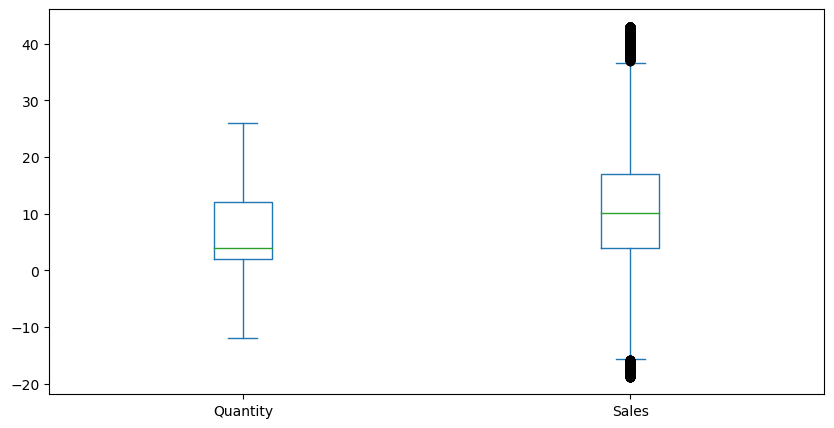

In [30]:
# Финально посмотрим на получившееся распределение
df_no_outliers[['Quantity', 'Sales']].plot(kind='box', figsize=(10, 5))
plt.show()

### ABC-анализ

ABC-анализ — это способ классификации ресурсов по степени их влияния на прибыль компании. Чаще всего применяется к товарному ассортименту для оценки рентабельности товаров и корректировки ассортимерной матрицы.

В результате ABC-анализа объекты делят на три группы:

- Группа A. Это самые ценные позиции: 20% товаров, приносящих 80% прибыли.
- Группа B. Промежуточные позиции — 30% товаров, приносящие 15% прибыли.
- Группа C. Наименее ценные позиции. Это 80% товаров, которые приносят 5% прибыли.

Наша цель анализа - оценка всего ассортимента для определения наиболее рентабельных товаров.

In [31]:
# Разделим товары на группы в зависимости от % прибыли
df_sales = df_no_outliers.groupby('Description').agg(value=('Sales','sum'))
df_sales['share'] = df_sales.value / df_sales.value.sum()
df_sales = df_sales.sort_values('share', ascending=False).reset_index()
df_sales['cum_sum'] = df_sales.share.cumsum()
df_sales['abc_sum'] = np.where(df_sales.cum_sum < 0.8, 'A', np.where(df_sales.cum_sum < 0.95, 'B', 'C'))
df_sales

,Description,value,share,cum_sum,abc_sum
0,WHITE HANGING HEART T-LIGHT HOLDER,26786.11,0.006482,0.006482,A
1,JUMBO BAG RED RETROSPOT,24590.60,0.005950,0.012432,A
2,ASSORTED COLOUR BIRD ORNAMENT,22794.72,0.005516,0.017948,A
3,PARTY BUNTING,22534.29,0.005453,0.023401,A
4,REGENCY CAKESTAND 3 TIER,21265.21,0.005146,0.028547,A
...,...,...,...,...,...
3831,ANTIQUE LILY FAIRY LIGHTS,-14.85,-0.000004,1.000109,C
3832,CREAM SWEETHEART MAGAZINE RACK,-16.95,-0.000004,1.000105,C
3833,BLUE PADDED SOFT MOBILE,-25.50,-0.000006,1.000098,C
3834,CRUK Commission,-30.57,-0.000007,1.000091,C


In [32]:
# Посчитаем получившиеся группы
df_sales.groupby('abc_sum', as_index=False)['Description'].count()

,abc_sum,Description
0,A,995
1,B,930
2,C,1911


После разбивки товаров на группы видно, что наиболее многичесленной является **группа С**, то есть примерно 50% ассортимертной матрицы приносят лишь 5% прибыли для компании. В качестве рекомендации предлагаю детальнее поработать с этой группой товаров и определить по каким категориям товаром можно уменьшить запасы, а от каких позиций лучше отказаться совсем.

Товары **группы А** требуеют дополнительного продвижения, нам выгодно их продавать. Их лучше всего упоминать в рассылках/пуш-уведомлениях/акциях, размещать рекламу с ними.

Товарами **группы B** мы будем поддерживать ассортимент.

### XYZ-анализ

XYZ-анализ - это метод, с помощью которого можно оценить стабильность спроса на определенные товарные позиции, степень влияения внешних факторов, таких как сезонность, рекмные кампании, тренды.

В результате XYZ-анализа объекты также делят тоже на три группы:

- Группа X. В неё входят объекты с коэффициентом вариативности 0–10%. Это значит, что спрос не меняется более, чем на 10% в месяц.
- Группа Y. В неё входят объекты с коэффициентом вариативности 10–25%.
- Группа Z. В неё входят товары с самым непредсказуемым спросом — объекты с коэффициентом вариативности больше 25%.

Цель анализа - скорректировать ассортимент продукции.

In [33]:
df_no_outliers['InvoiceDate'] = pd.to_datetime(df_no_outliers['InvoiceDate']).dt.date

C:\Users\dbellkoff\AppData\Local\Temp\ipykernel_24012\3764294819.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_outliers['InvoiceDate'] = pd.to_datetime(df_no_outliers['InvoiceDate']).dt.date


In [34]:
# Посчитаем количество каждого проданного товара
df_quantity = df_no_outliers.groupby(['InvoiceDate', 'Description']).agg({'Quantity':'sum'}).reset_index()
df_quantity.head()

,InvoiceDate,Description,Quantity
0,2010-12-01,4 PURPLE FLOCK DINNER CANDLES,2
1,2010-12-01,SET 2 TEA TOWELS I LOVE LONDON,15
2,2010-12-01,10 COLOUR SPACEBOY PEN,48
3,2010-12-01,12 DAISY PEGS IN WOOD BOX,3
4,2010-12-01,12 MESSAGE CARDS WITH ENVELOPES,6


In [35]:
# Еще раз сгруппируем данные и теперь посчитаем кол-во проданных позиций в каждую из дат
df_grouped = df_quantity.groupby('Description', as_index=False).agg({'InvoiceDate':'count'})

# Далее выберем только те товары, которые продавались более 1 раза и сохраним их в отдельной список
xyz_names = list(df_grouped[df_grouped['InvoiceDate'] > 1]['Description'])

In [36]:
# Отфильтруем датафрейм по получившемуся списку
df_quantity = df_quantity[df_quantity['Description'].isin(xyz_names)]

In [37]:
# Посчитаем коэффициент вариации
df_quantity = df_quantity.groupby('Description', as_index=False).apply(lambda x: x.std() / x.mean())

C:\Users\dbellkoff\AppData\Local\Temp\ipykernel_24012\3805821564.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_quantity = df_quantity.groupby('Description', as_index=False).apply(lambda x: x.std() / x.mean())


In [38]:
# Разобьем товары на группы
df_quantity['xyz'] = np.where(df_quantity['Quantity'] < 0.1, 'X', np.where(df_quantity['Quantity'] < 0.25, 'Y', 'Z'))
df_quantity

,Description,Quantity,xyz
0,4 PURPLE FLOCK DINNER CANDLES,1.223387,Z
1,50'S CHRISTMAS GIFT BAG LARGE,0.625702,Z
2,DOLLY GIRL BEAKER,0.879047,Z
3,I LOVE LONDON MINI BACKPACK,0.686355,Z
4,NINE DRAWER OFFICE TIDY,0.394968,Z
...,...,...,...
3604,ZINC T-LIGHT HOLDER STARS SMALL,0.655309,Z
3605,ZINC TOP 2 DOOR WOODEN SHELF,0.314270,Z
3606,ZINC WILLIE WINKIE CANDLE STICK,0.709342,Z
3607,ZINC WIRE KITCHEN ORGANISER,1.002220,Z


In [39]:
# Посчитаем получившиеся группы
df_quantity.groupby('xyz', as_index=False).agg({'Description':'count'})

,xyz,Description
0,X,130
1,Y,25
2,Z,3454


Товары **группы X** продаются стабильно хорошо, поэтому они всегда должны быть в наличии на складе. В рамках этой группы можно провести еще один xyz-анализ, чтобы понять есть ли какие-то дополнительные предпочтения у аудитории (например, чаще покупают товары в синем цвете, в деревянной фактурой и пр.).

Товары **группы Y** продавались значительно хуже. Создавать для них дополнительные запасы сейчас точно не имеет смысла, важнее понять с чем у них связаны колебания в спросе. Возможно есть какая-то сезонность.

Товары **группы Z** оказались наиболее многочисленными. Необходимо провести дополнительный анализ внутри данной группы, чтобы определить какие-то факторы так сильно влияют на спрос.